In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [262]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


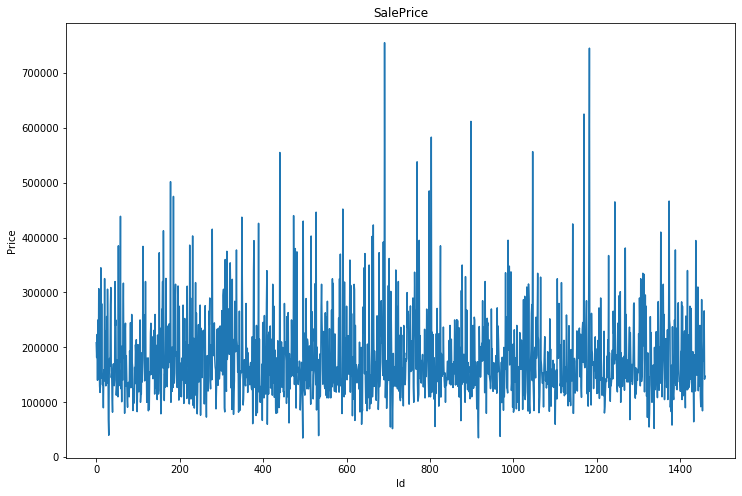

In [5]:
train.SalePrice.plot(figsize=(12,8))
plt.title('SalePrice')
plt.ylabel('Price')
plt.xlabel('Id');

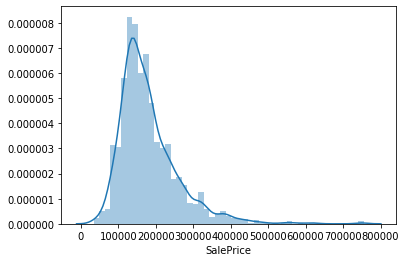

In [7]:
sns.distplot(train.SalePrice);

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

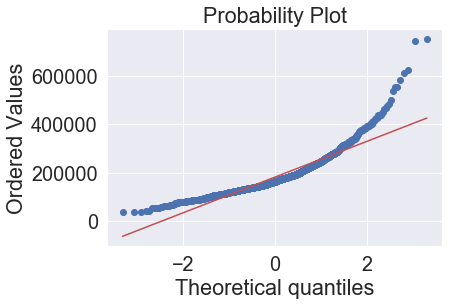

In [40]:
stats.probplot(train.SalePrice,plot=plt)

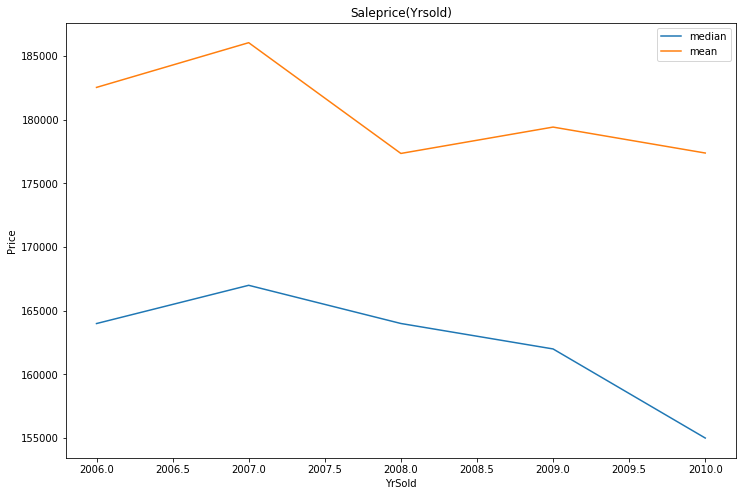

In [8]:
train.groupby('YrSold').agg([np.median,np.mean]).SalePrice.plot(figsize=(12,8))
plt.ylabel('Price')
plt.title('Saleprice(Yrsold)');

In [9]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [263]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
categoric = np.where(train.dtypes=='object')[0]
print('Numerical features : ',train.columns[numeric].values,'\nAmount: ',len(numeric))
print('Categorical features : ',train.columns[categoric].values,'\nAmount:',len(categoric))

Numerical features :  ['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice'] 
Amount:  38
Categorical features :  ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'Gara

In [104]:
train.RoofStyle.unique()

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

In [11]:
for column in categoric:
    print('unique values in column {}: '.format(train.columns[column]),len(train.iloc[:,column].unique()))

unique values in column MSZoning:  5
unique values in column Street:  2
unique values in column Alley:  3
unique values in column LotShape:  4
unique values in column LandContour:  4
unique values in column Utilities:  2
unique values in column LotConfig:  5
unique values in column LandSlope:  3
unique values in column Neighborhood:  25
unique values in column Condition1:  9
unique values in column Condition2:  8
unique values in column BldgType:  5
unique values in column HouseStyle:  8
unique values in column RoofStyle:  6
unique values in column RoofMatl:  8
unique values in column Exterior1st:  15
unique values in column Exterior2nd:  16
unique values in column MasVnrType:  5
unique values in column ExterQual:  4
unique values in column ExterCond:  5
unique values in column Foundation:  6
unique values in column BsmtQual:  5
unique values in column BsmtCond:  5
unique values in column BsmtExposure:  5
unique values in column BsmtFinType1:  7
unique values in column BsmtFinType2:  7

In [264]:
def cleaning_na(data):
    columns_with_na = np.where(data.isna().sum()>0)[0]
    columns_to_drop = (data.iloc[:,columns_with_na].isna().sum()/data.shape[0]*100)>40
    columns_number = columns_with_na[np.where((data.iloc[:,columns_with_na].dtypes=='float')|(data.iloc[:,columns_with_na].dtypes=='int'))[0]]
    columns_cat =  columns_with_na[np.where(data.iloc[:,columns_with_na].dtypes=='object')[0]]
    data.iloc[:,columns_number] = data.iloc[:,columns_number].apply(lambda x:x.fillna(x.median()))
    for column in columns_cat:
        data.iloc[:,column].fillna(data.iloc[:,column].mode()[0],inplace=True)
    data.drop(data.columns[columns_with_na[columns_to_drop]],axis=1,inplace=True)
    data.drop('Id',axis=1,inplace=True)
cleaning_na(train)
cleaning_na(test)
train.to_csv('train_clean.csv',index=None)
test.to_csv('test_clean.csv',index=None) 

In [13]:
corr = train.corr()

Text(0.5, 1, 'Correlation')

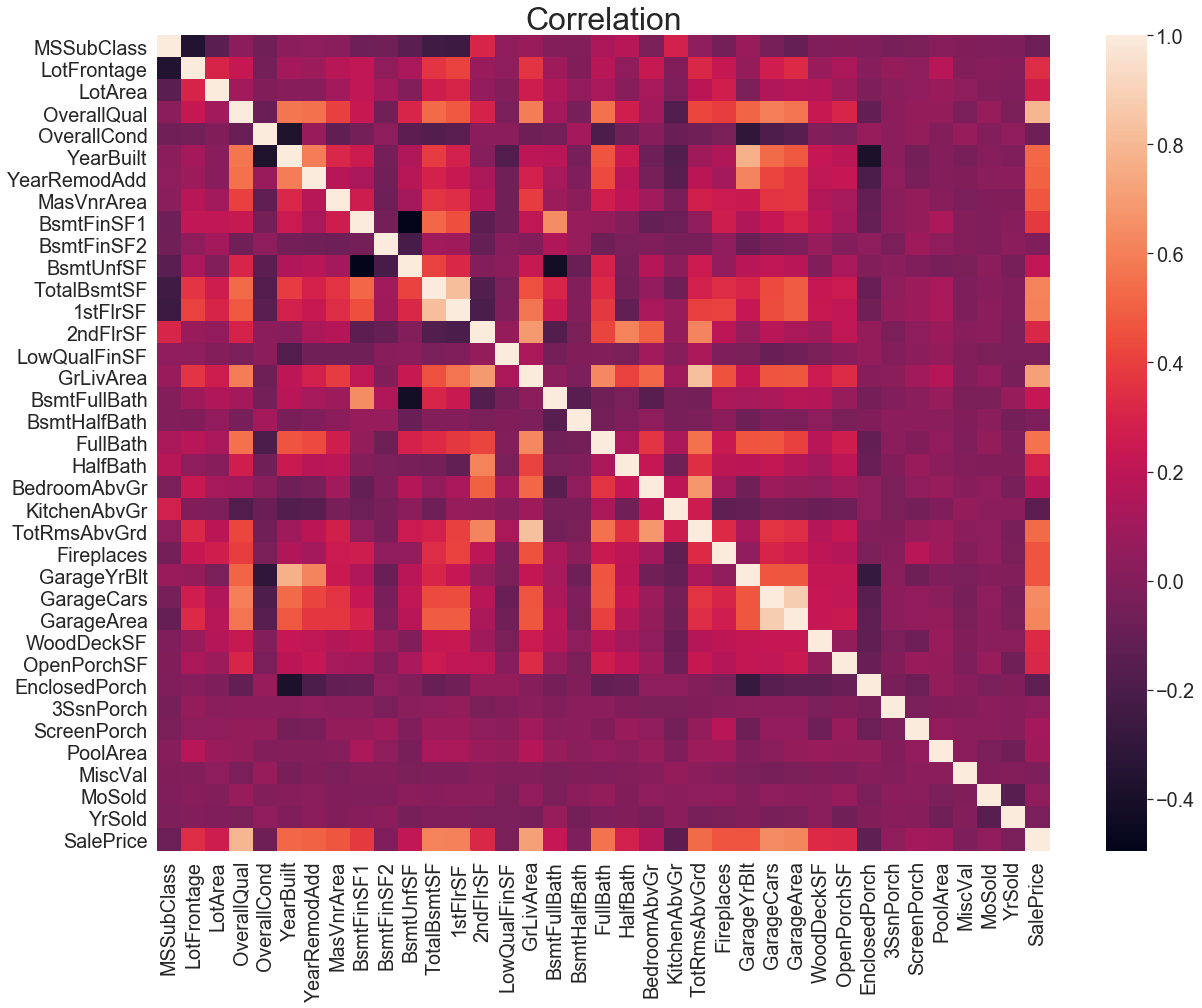

In [14]:
plt.figure(figsize=(20,15))
sns.set(font_scale=1.8)
sns.heatmap(corr)
plt.title('Correlation',fontsize=32)

In [15]:
train.groupby(['CentralAir','Electrical','Heating'])[['SalePrice']].median()

SalePrice
CentralAir Electrical Heating           
N          FuseA      GasA        106125
                      GasW        239000
                      Grav         60000
                      Wall         90200
           FuseF      GasA        105750
                      GasW         98500
                      Grav        100000
                      Wall         94000
           FuseP      GasA         82000
           SBrkr      Floor        72500
                      GasA         99000
                      GasW        133900
                      Grav         67200
                      OthW        125750
Y          FuseA      GasA        125000
                      GasW        144000
           FuseF      GasA        130000
           Mix        GasA         67000
           SBrkr      GasA        173000
                      GasW        225000

In [16]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
pear = {}
spear = {}
for col in numeric:
    col_name = train.columns[col]
    pear[col_name] = stats.pearsonr(train[col_name],train['SalePrice'])[0]
    spear[col_name] = stats.spearmanr(train[col_name],train['SalePrice'])[0]

In [17]:
print('Statistically insignificant(pearson corr)')
feat_to_drop_pear = {}
for feature in pear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_pear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_pear))

Statistically insignificant(pearson corr)
BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
dtype: float64


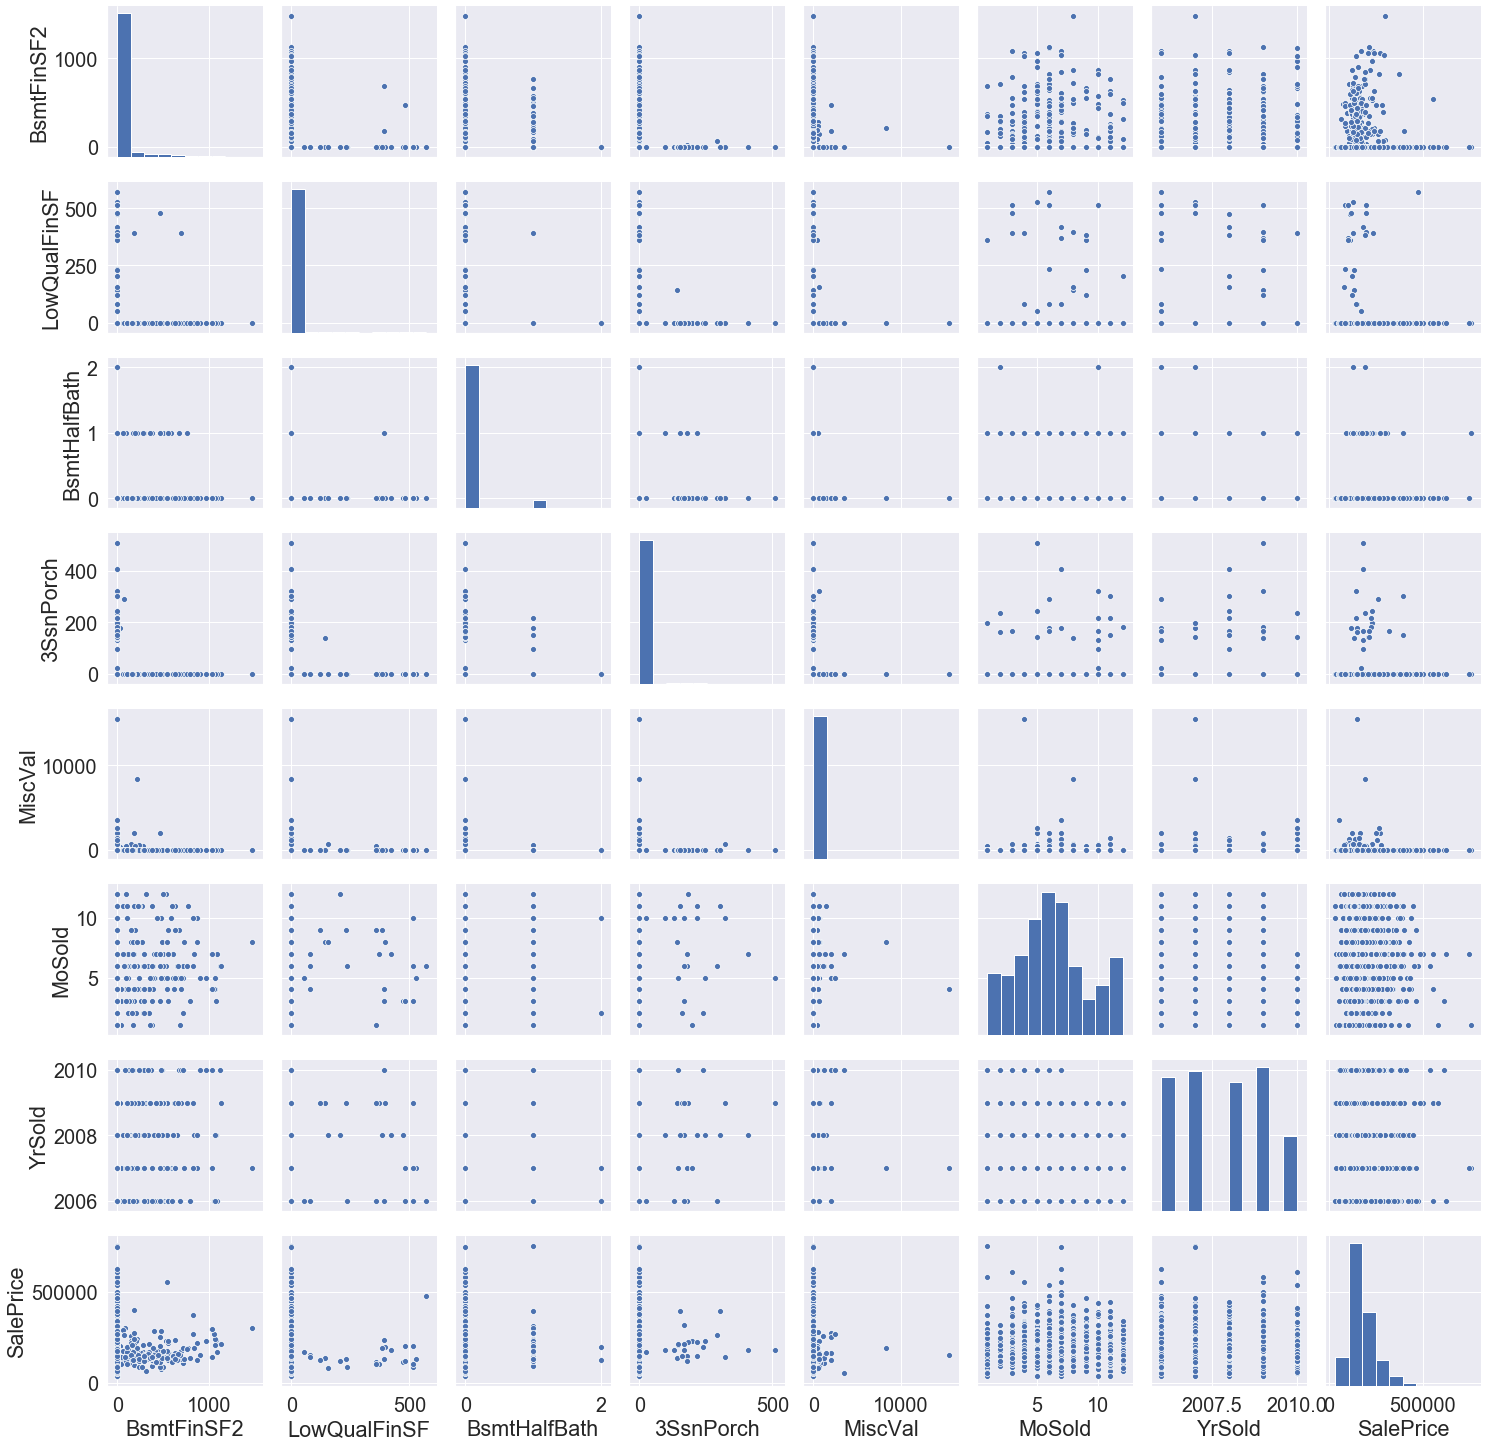

In [18]:
feat_to_draw = list(feat_to_drop_pear)
feat_to_draw.append('SalePrice')
sns.pairplot(train.loc[:,feat_to_draw]);

In [19]:
print('Statistically insignificant(spearman corr)')
feat_to_drop_spear = {}
for feature in spear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_spear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_spear))

Statistically insignificant(spearman corr)
MSSubClass      0.007192
BsmtFinSF2     -0.038806
BsmtHalfBath   -0.012189
YrSold         -0.029899
dtype: float64


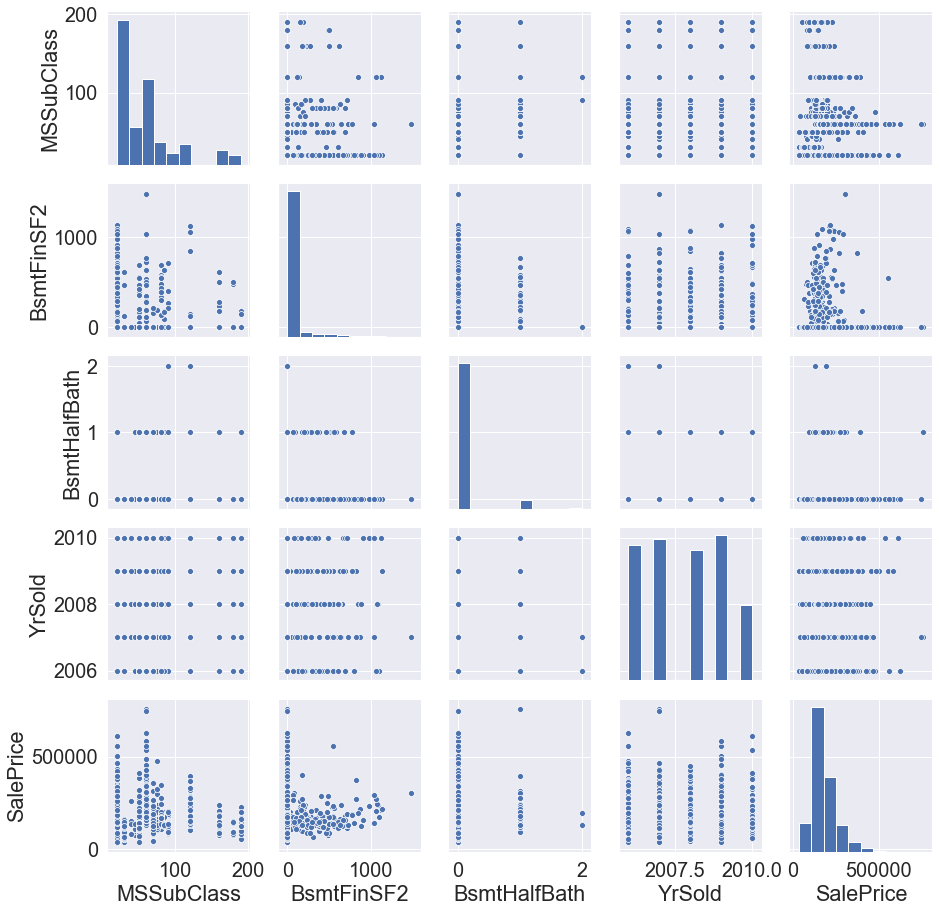

In [20]:
feat_to_draw = list(feat_to_drop_spear)
feat_to_draw.append('SalePrice')
sns.pairplot(train.loc[:,feat_to_draw]);

In [21]:
train.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
feats = list(train.columns[numeric].drop('SalePrice'))
features_string = " + ".join(feats)

In [22]:
m1 = smf.ols('SalePrice ~ ' + features_string , data=train)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     182.4
Date:                Fri, 11 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:56:45   Log-Likelihood:                -17319.
No. Observations:                1460   AIC:                         3.471e+04
Df Residuals:                    1425   BIC:                         3.489e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.628e+05   1.41e+06      0.327

In [23]:
feats = np.array(feats)
feats_pvalue = fitted.pvalues>0.65
feats[feats_pvalue[1:]]

array(['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GarageArea',
       'OpenPorchSF', 'MiscVal', 'MoSold'], dtype='<U13')

In [24]:
#can be dropped
set(feat_to_drop_pear).union(set(feat_to_drop_spear)).union(set(feats[feats_pvalue[1:]]))

{'3SsnPorch',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'LowQualFinSF',
 'MSSubClass',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'YrSold'}

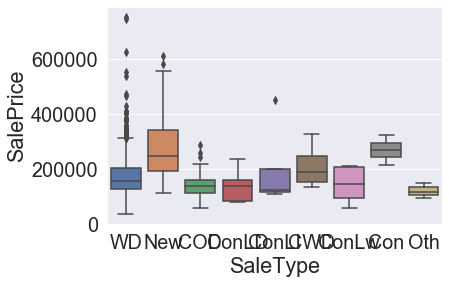

In [25]:
sns.boxplot(train.SaleType,train.SalePrice)

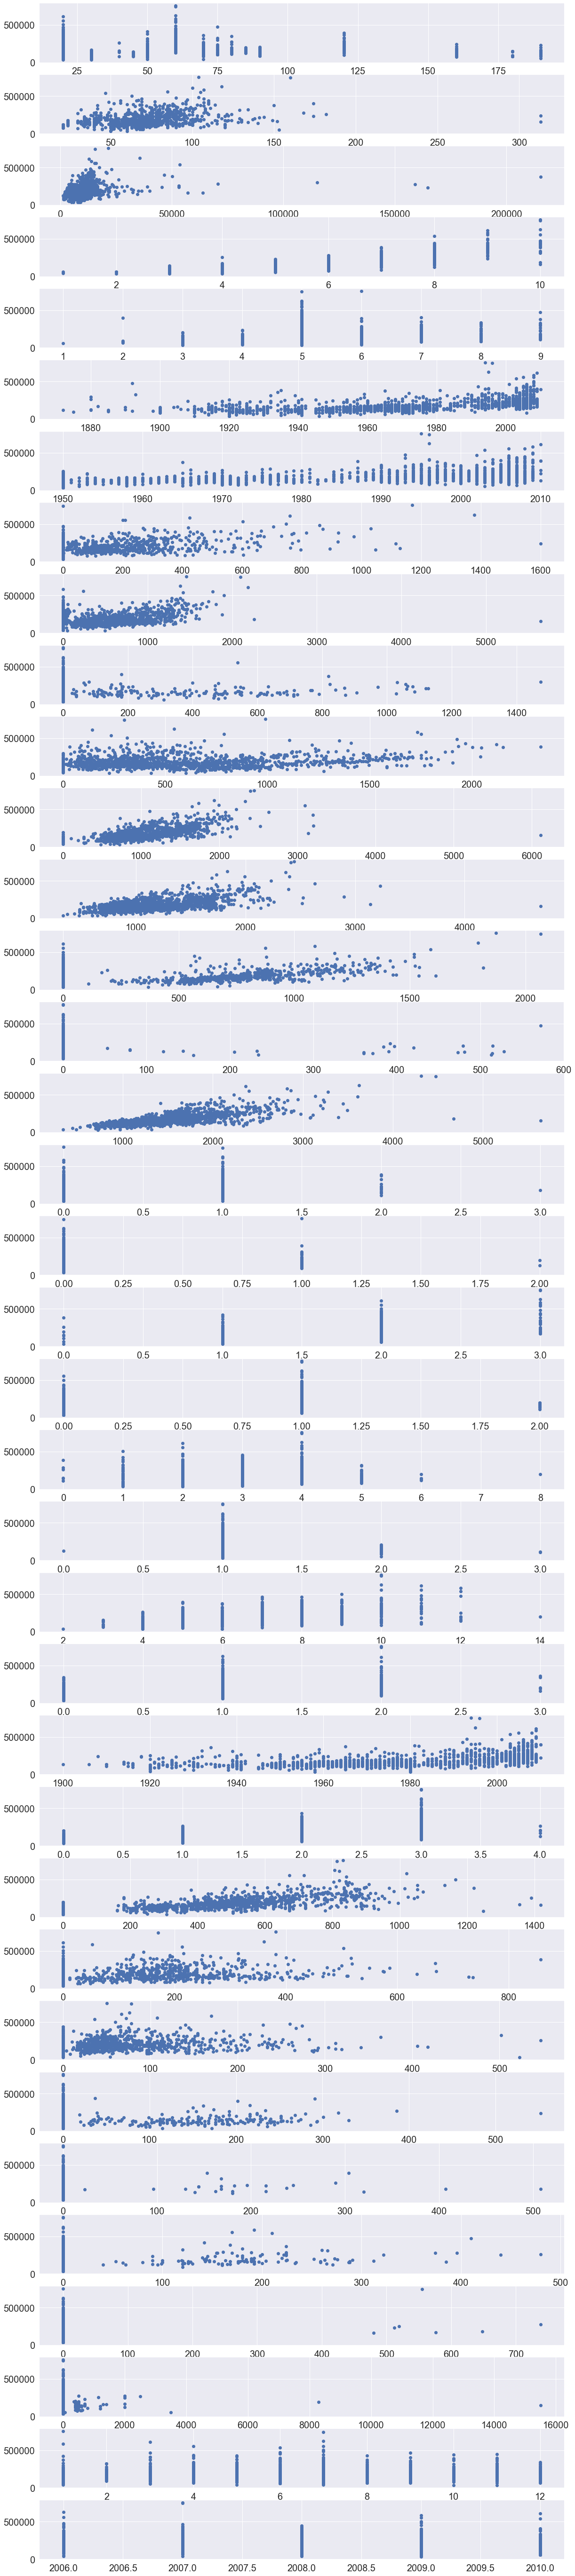

In [75]:
plt.figure(figsize=(20,100))
for i in range(len(numeric)):
    plt.subplot(len(numeric),1,i+1)
    plt.scatter(train.iloc[:,numeric[i]],train.SalePrice)

In [265]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV,LogisticRegression,RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor

In [266]:
X = train.drop('SalePrice',axis=1)
y = train.SalePrice
categorical_cols = np.where(X.dtypes=='object')[0]
numerical_cols = np.where((X.dtypes=='float')|(X.dtypes=='int'))[0]

In [23]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [267]:
scaler = StandardScaler()
cat = OneHotEncoder(handle_unknown='ignore')

In [268]:
X.iloc[:,numerical_cols] = scaler.fit_transform(X.iloc[:,numerical_cols])
test.iloc[:,numerical_cols] = scaler.transform(test.iloc[:,numerical_cols])
X_cat = cat.fit_transform(X.iloc[:,categorical_cols])
test_cat = cat.transform(test.iloc[:,categorical_cols])

In [ ]:
#X.drop(X.columns[categorical_cols],axis=1,inplace=True)
#test.drop(test.columns[categorical_cols],axis=1,inplace=True)

In [269]:
X_all = X.drop(X.columns[categorical_cols],axis=1,inplace=True)
test_all = test.drop(test.columns[categorical_cols],axis=1,inplace=True)
X_all = np.hstack((X,X_cat.toarray()))
test_all = np.hstack((test,test_cat.toarray()))

In [ ]:
logit = LogisticRegression(random_state=5)
logit.fit(X,y)
logit.predict(test)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
model = LogisticRegressionCV(random_state=5)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
my_pipeline.fit(X,y)
# Preprocessing of training data, fit model 
#print(cross_val_score(my_pipeline,X,y,cv=5))

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(test)


In [30]:
numeric = np.where((X.dtypes == 'int')|(X.dtypes == 'float'))[0]

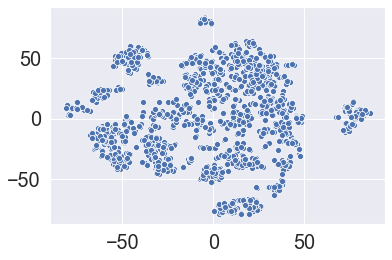

In [53]:
tsne = TSNE(perplexity=10,random_state=5)
tsne_result = tsne.fit_transform(X.iloc[:,numeric])
sns.scatterplot(tsne_result[:,1],tsne_result[:,0])

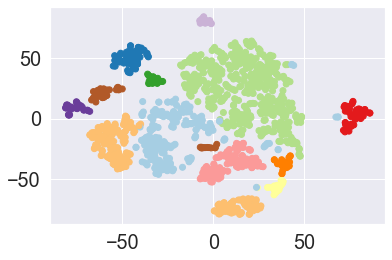

In [54]:
dbscan = DBSCAN(eps=6,min_samples=10).fit_predict(tsne_result)
plt.scatter(tsne_result[:,1],tsne_result[:,0],c=dbscan,cmap='Paired')

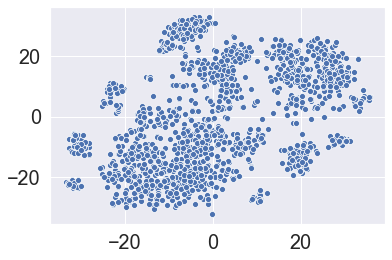

In [34]:
tsne = TSNE(perplexity=50,random_state=5)
tsne_result = tsne.fit_transform(X.iloc[:,numeric])
sns.scatterplot(tsne_result[:,1],tsne_result[:,0])

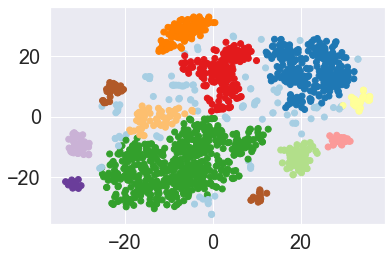

In [45]:
dbscan = DBSCAN(eps=2.5,min_samples=10).fit_predict(tsne_result)
plt.scatter(tsne_result[:,1],tsne_result[:,0],c=dbscan,cmap='Paired')

In [94]:
from tensorflow import keras
import tensorflow as tf

In [95]:
tf.__version__

'1.13.1'

In [26]:
from sklearn.linear_model import Lasso,lasso_path,lars_path

In [106]:
numeric=np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]

In [107]:
lasso = Lasso(alpha=50,random_state=5)
fitted = lasso.fit(X.iloc[:,numeric],y)

In [108]:
pd.DataFrame({'coef':fitted.coef_},index = train.columns[numeric]).sort_values(by='coef')

,coef
YearRemodAdd,-8025.024306
Id,-7557.751836
RoofStyle,-2647.874658
BsmtExposure,-1124.737064
MSSubClass,-1100.504056
Condition2,-1082.751044
BsmtFinType2,-972.162790
YearBuilt,-762.740905
MasVnrArea,-382.745342
BsmtFinType1,-307.730700


In [34]:
alphas,coefs,_ = lasso_path(X.iloc[:,numeric],y)

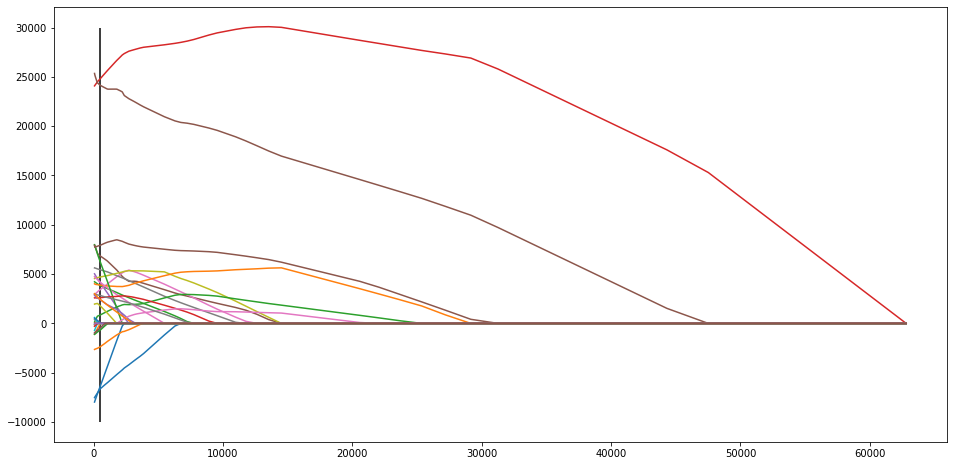

In [59]:
plt.figure(figsize=(16,8))
plt.plot(alphas,coefs.T);
plt.xlim()
plt.vlines(500,-10000,30000)

In [74]:
X_all.shape

(1460, 270)

In [86]:
lasso = Lasso(alpha=100,random_state=5)
fitted = lasso.fit(X_all,y)
(pd.DataFrame({'coef':fitted.coef_}).sort_values(by='coef')!=0).sum()

coef    110
dtype: int64

In [85]:
forest = RandomForestRegressor(random_state=5)
forest.fit(X_all,y);

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [91]:
forest.predict(test_all)

array([128587.5 , 154675.  , 180397.67, ..., 153700.02, 117057.59,
       220353.99])

In [92]:
lasso.predict(test_all)

array([113854.3501151 , 152788.77417509, 180281.1529401 , ...,
       164804.21317666, 105553.68711812, 221460.36007075])

In [160]:
from tensorflow.python.keras.metrics import Metric

In [253]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError())


In [254]:
X_tf = tf.convert_to_tensor(X_all)
y_tf = tf.convert_to_tensor(y.values.astype('float'))
test_tf = tf.convert_to_tensor(test_all)

In [258]:
model.fit(X_tf,y_tf,steps_per_epoch=10,epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 18ms/step - loss: 25777849344.0000
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 20364192563.2000
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 14685597081.6000
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 9875121766.4000
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 7076402636.8000
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 6339049011.2000
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 6384974848.0000
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 6360302233.6000
Epoch 9/10
10/10 [==============================] - 0s 14ms/step - loss: 6314689228.8000
Epoch 10/10
10/10 [==============================] - 0s 14ms/step - loss: 6309405337.6000


In [246]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         multiple                  0         
_________________________________________________________________
dense_48 (Dense)             multiple                  69376     
_________________________________________________________________
dense_49 (Dense)             multiple                  32896     
_________________________________________________________________
dense_50 (Dense)             multiple                  8256      
_________________________________________________________________
dense_51 (Dense)             multiple                  65        
Total params: 110,593
Trainable params: 110,593
Non-trainable params: 0
_________________________________________________________________


In [259]:
pred = model.predict(test_tf,steps=10).tolist()

In [270]:
lasso = LassoCV(random_state=5).fit(X_all,y)
pred = lasso.predict(test_all)
pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':pred}).to_csv('lassocv.csv',index=False)

In [281]:
forest = RandomForestRegressor(random_state=5,n_estimators=2000).fit(X_all,y)
pred = forest.predict(test_all)
pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':pred}).to_csv('forest.csv',index=False)

In [282]:
PCA?

In [284]:
pca = PCA(n_components=100,random_state=5)
X_pca = pca.fit_transform(X_all)
test_pca = pca.transform(test_all)

In [285]:
forest = RandomForestRegressor(random_state=5,n_estimators=2000).fit(X_pca,y)
pred = forest.predict(test_pca)
pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':pred}).to_csv('forest_pca.csv',index=False)